# Task

1. Split strategy implementation:
* Split strategy MC control algorithm for Acrobot environment from OpenAI Gym library.
* Random behavioral strategy for data collection and training of target strategy.

2. Parameter optimization:
* Experiments with different parameter values ​​(e.g. discount factor gamma, number of episodes n_episode, ε for ε-greedy strategy).
* Optimal parameter values ​​that lead to the best results in training.

3. Strategy comparison:
* Comparison of the optimal strategy obtained using the split strategy with the optimal strategy obtained using the ε-greedy strategy.
* Analysis of which strategy gives the best results in Acrobot environment.

4. Results visualization:
* Q-function and strategy for Acrobot environment.
* Using matplotlib library for plotting and surface plots to visualize the results.

5. Additional:
* Monte Carlo method with a split strategy for the LunarLander environment from the OpenAI Gym library.
* Analysis of how the Q-function and strategy change during training for a new environment.

# Installing and importing libraries and modules

In [ ]:
!pip install --upgrade gym pyvirtualdisplay numpy ipykernel > /dev/null 2>&1

In [ ]:
# PyTorch — for working with tensors and calculations (e.g. argmax)
import torch

# OpenAI Gym — a library for interacting with RL environments, e.g. Acrobot-v1
import gym

# Because gym doesn't have LunarLander, so we additionally use the gymnasium fork
import gymnasium

# NumPy — for working with arrays and mathematical operations (including discretization of states)
import numpy as np

# defaultdict from collections — a convenient alternative to dict for storing Q-functions and statistics
from collections import defaultdict

# Seaborn — a library for beautiful data visualization (heat maps of Q-functions and policies)
import seaborn as sns

# Matplotlib — a basic library for plotting graphs
import matplotlib
import matplotlib.pyplot as plt # pyplot — an interface for drawing graphs

# Module for 3D graphs (if you need to visualize the Q-function in three dimensions)
from mpl_toolkits.mplot3d import Axes3D

# Fix for compatibility: some libraries do not support new numpy types
np.bool8 = np.bool_ # Replacement obsolete type np.bool8 to current np.bool_
np.float_ = np.float64 # Fix for some versions of numpy and matplotlib

# Monte Carlo Method with Split Strategy for Acrobot Environment

### Creating an Acrobot environment

The Acrobot-v1 environment is a task of controlling a two-jointed manipulator (two rods connected by a hinge), the goal of which is to lift the end of the second rod above a certain level.

Features:

State space: 6-dimensional vector of continuous values ​​(Box(6,))

Action space is discrete, with 3 possible actions:

0 — apply a negative torque,

1 — do not apply a torque,

2 — apply a positive torque

In [ ]:
env = gym.make('Acrobot-v1', render_mode="rgb_array")

In [ ]:
state, _ = env.reset()

### Algorithm with a greedy strategy

Since state is an array of 6 floating point numbers, e.g. [cosθ₁, sinθ₁, cosθ₂, sinθ₂, ω₁, ω₂], we need to convert it to discrete form to use it as a key in the dictionary Q.

In [ ]:
def discretize_state(state, bins):
    """
    Discretizes continuous state into "bins"
    @param state: current state (np.array)
    @param bins: list of arrays, where each array contains bins for the corresponding dimension
    @return: discretized state as a tuple
    """
    discrete_state = [np.digitize(state[i], bins[i]) - 1 for i in range(len(state))]
    return tuple(discrete_state)

It is necessary to create a binning (partition) for each dimension of the state
For example, you can use 5 bins for each of the 6 dimensions:

In [ ]:
# Number of bins for each of the 6 state components
num_bins = 5

# Boundaries for each parameter (can be selected empirically)
state_bounds = [
    [-1.0, 1.0],  # cos(theta1)
    [-1.0, 1.0],  # sin(theta1)
    [-1.0, 1.0],  # cos(theta2)
    [-1.0, 1.0],  # sin(theta2)
    [-4.0, 4.0],  # angular velocity theta1
    [-9.0, 9.0]   # angular velocity theta2
]

# Create a bin grid
bins = [np.linspace(low, high, num_bins + 1) for low, high in state_bounds]

Let's write a function that executes one episode, taking the actions dictated by the $Q$-function. This is the improvement stage.

In [ ]:
def run_episode(env, Q, n_action, bins):
    """
    Executes an episode guided by a given Q-function
    @param env: OpenAI Gym environment
    @param Q: Q-function (dictionary, where key is a discretized state as a tuple)
    @param n_action: action space
    @param bins: list of bins to discretize the state
    @return: resulting states, actions, and rewards for the entire episode
    """
    state, _ = env.reset()
    discrete_state = discretize_state(state, bins)

    rewards = []
    actions = []
    states = []

    action = torch.randint(0, n_action, [1]).item()

    while True:
        actions.append(action)
        states.append(discrete_state)

        next_state, reward, done, terminated, info = env.step(action)
        rewards.append(reward)

        if done or terminated:
            break

        next_discrete_state = discretize_state(next_state, bins)
        action = torch.argmax(Q[next_discrete_state]).item()

        discrete_state = next_discrete_state

    return states, actions, rewards

And now the algorithm itself. We implement the algorithm of MC control with a single strategy.

In [ ]:
def mc_control_on_policy(env, gamma, n_episode, bins):
    """
    Finds the optimal strategy using the MC control method with a single strategy
    @param env: OpenAI Gym environment name
    @param gamma: discount coefficient
    @param n_episode: number of episodes
    @return: optimal Q-function and optimal strategy
    """
    # Number of possible actions in the environment
    n_action = env.action_space.n

    # Sum of returns for each (state, action) pair
    G_sum = defaultdict(float)

    # Number of visits to each (state, action) pair
    N = defaultdict(int)

    # Q-function initialized with zero tensors of size n_action
    Q = defaultdict(lambda: torch.zeros(n_action))

    # List of rewards to visualize
    episode_rewards = []

    # Loop through all episodes
    for episode in range(n_episode):
        # Run episode using current Q function
        states_t, actions_t, rewards_t = run_episode(env, Q, n_action, bins)

        # Initialize return for current episode
        return_t = 0

        # Dictionary to store returns for each (state, action) pair
        G = {}

        # Walk backwards through episode (last state to first)
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            # Calculate return taking into account depreciation
            return_t = gamma * return_t + reward_t

            # Store return for current (state, action) pair
            G[(state_t, action_t)] = return_t

        # Updating Q-function based on returns
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1

            # Update average return for current pair (state, action)
            Q[state][action] = G_sum[state_action] / N[state_action]

        episode_rewards.append(sum(rewards_t))

    # Formation of an optimal strategy based on the Q-function
    policy = {}
    for state, actions in Q.items():
        # Selecting the action with the maximum value of the Q-function
        policy[state] = torch.argmax(actions).item()

    # Return of the optimal Q-function and strategy
    return Q, policy, episode_rewards

Let's set the depreciation factor to 1 and the number of episodes to 500,000:

In [ ]:
gamma = 0.99
n_episode = 1000

Let us implement the MC control algorithm with a single strategy to find the optimal Q-function and strategy:

In [ ]:
optimal_Q, optimal_policy, episode_rewards = mc_control_on_policy(env, gamma, n_episode, bins)
print(optimal_policy)

Let's calculate the value function for the optimal strategy and print it out:

In [ ]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()
print(optimal_value)

Experimenting with parameters

In [ ]:
def run_experiments(param_grid, env_name='Acrobot-v1', num_bins=5):
    results = []
    env = gym.make(env_name)

    state_bounds = [
        [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0],
        [-1.0, 1.0], [-4.0, 4.0], [-9.0, 9.0]
    ]
    bins = [np.linspace(low, high, num_bins + 1) for low, high in state_bounds]

    plt.figure(figsize=(12, 6))

    for idx, params in enumerate(param_grid):
        print(f"\nTraining with parameters: {params}")
        gamma = params['gamma']
        n_episode = params['n_episode']

        Q, policy, rewards = mc_control_on_policy(
            env, gamma, n_episode, bins)

        smoothed_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed_rewards, label=str(params))

        results.append({
            'params': params,
            'Q': Q,
            'policy': policy,
            'rewards': rewards
        })

    plt.title("Average reward per episode (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    env.close()
    return results


Training with parameters: {'gamma': 0.9, 'n_episode': 2000}

Training with parameters: {'gamma': 0.99, 'n_episode': 2000}

Training with parameters: {'gamma': 0.9, 'n_episode': 5000}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000}


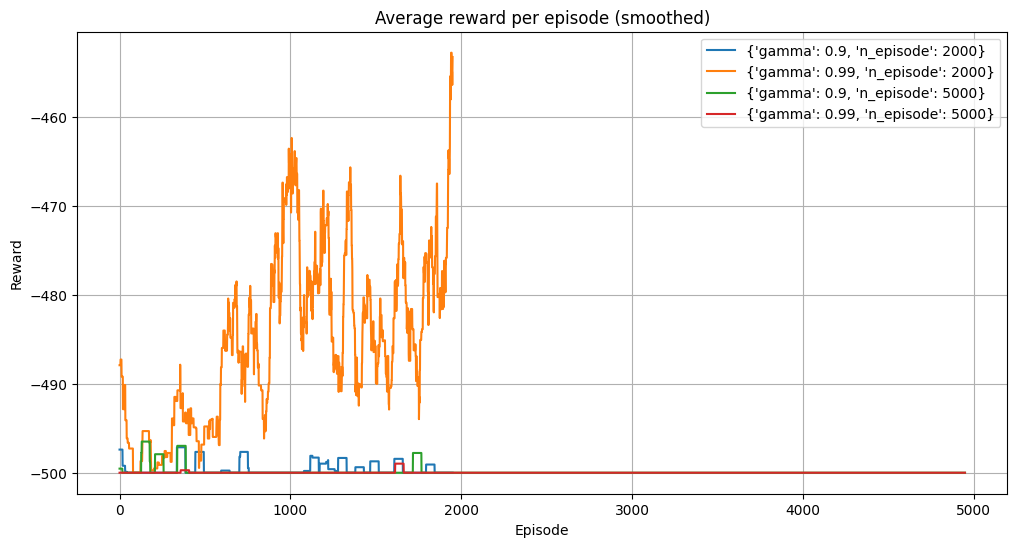

In [ ]:
param_grid = [
    {'gamma': 0.9, 'n_episode': 2000},
    {'gamma': 0.99, 'n_episode': 2000},
    {'gamma': 0.9, 'n_episode': 5000},
    {'gamma': 0.99, 'n_episode': 5000}
]

results = run_experiments(param_grid)

In the Acrobot environment in OpenAI Gym, negative reward (-1 per step) is used to incentivize the agent to reach the goal state (swinging the end of the bottom link to a given height) as quickly as possible. Since the agent starts upside down, it needs to actively swing the links to reach the goal, and the negative reward signals that each step taken takes it further away from the goal state. This incentivizes the agent to find a policy that minimizes the number of steps to reach the goal, making the learning process more efficient.

Negative reward as a time penalty:
Each time step entails a negative reward, which is effectively a penalty for taking more steps.
Efficiency reward:
By penalizing each step, the agent is motivated to find the shortest path to the goal state, resulting in a more efficient policy.

Visualization of Q-function and policy

In [ ]:
def visualize_q_and_policy(result, action_idx=1, grid_size=None):
    Q = result['Q']
    policy = result['policy']

    # Automatically determine the maximum indices from all states
    max_x = max(s[0] for s in Q) + 1
    max_y = max(s[1] for s in Q) + 1
    if grid_size is not None:
        max_x = max(max_x, grid_size)
        max_y = max(max_y, grid_size)

    q_values = np.zeros((max_x, max_y))
    policy_grid = np.zeros((max_x, max_y))

    for s in Q:
        x, y = s[0], s[1]
        q_values[x, y] += Q[s][action_idx].item()
        policy_grid[x, y] = policy[s]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=False)
    plt.title(f"Q(s, a={action_idx})")

    plt.subplot(1, 2, 2)
    sns.heatmap(policy_grid, annot=True, cmap="viridis", cbar=False)
    plt.title("Policy (a = argmax Q)")

    plt.tight_layout()
    plt.show()

Let's visualize the best result:

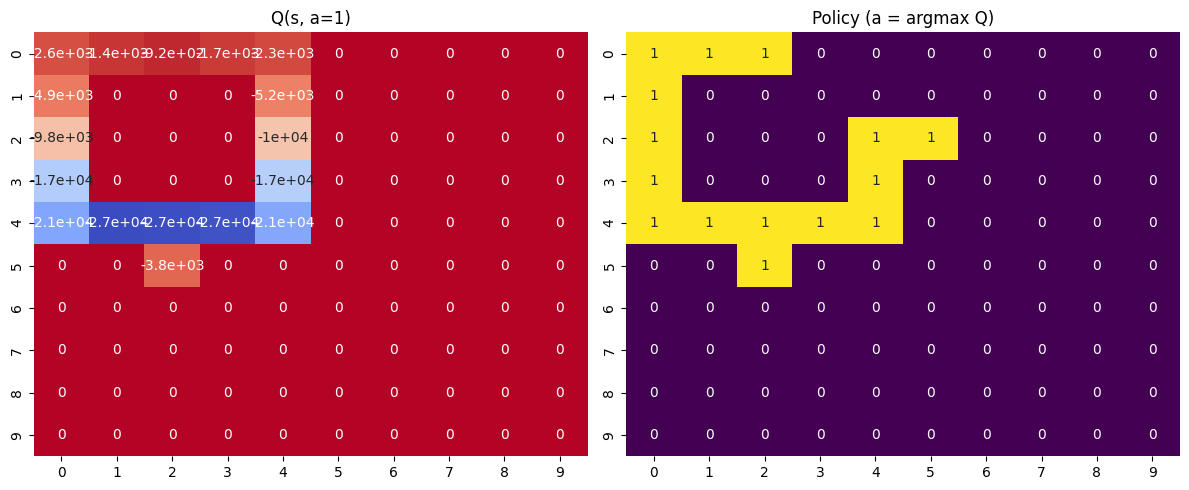

In [ ]:
visualize_q_and_policy(results[1], grid_size=10)

### Algorithm with $𝛆$-greedy strategy

In [ ]:
def run_episode_epsilon_greedy(env, Q, n_action, bins, epsilon=0.1):
    """
    Executes an episode guided by a given Q-function using an ε-greedy strategy.
    @param env: OpenAI Gym environment
    @param Q: Q-function (dictionary, where key is a discretized state as a tuple)
    @param n_action: action space
    @param bins: list of bins to discretize the state
    @param epsilon: probability of a random action
    @return: resulting states, actions, and rewards for the entire episode
    """
    state, _ = env.reset()
    discrete_state = discretize_state(state, bins)

    rewards = []
    actions = []
    states = []

    while True:
        # ε-greedy choice of action
        if torch.rand(1).item() < epsilon:
            action = torch.randint(0, n_action, [1]).item()  # random action
        else:
            action = torch.argmax(Q[discrete_state]).item()  # greedy action

        actions.append(action)
        states.append(discrete_state)

        next_state, reward, done, terminated, info = env.step(action)
        rewards.append(reward)

        if done or terminated:
            break

        discrete_state = discretize_state(next_state, bins)

    return states, actions, rewards

In [ ]:
def mc_control_epsilon_greedy(env, gamma, n_episode, bins, epsilon=0.1):
    """
    Finds the optimal strategy using the MC control method with a single ε-greedy strategy
    @param env: OpenAI Gym environment name
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param bins: list of bins to discretize states
    @param epsilon: probability of a random action
    @return: optimal Q-function, policy, and reward history
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(n_action))  # Initialize Q(s,a)
    episode_rewards = [] # To store episode rewards

    for episode in range(n_episode):
        # Collecting a trajectory with the current policy (ε-greedy)
        states_t, actions_t, rewards_t = run_episode_epsilon_greedy(env, Q, n_action, bins, epsilon)

        # Keeping the overall reward for the episode
        episode_rewards.append(sum(rewards_t))

        return_t = 0
        G = {}

        # Episode Rewind
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t

        # Q-function update
        for state_action, return_t in G.items():
            state, action = state_action
            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]

    # Construction of an optimal policy
    policy = {s: torch.argmax(q).item() for s, q in Q.items()}

    return Q, policy, episode_rewards

Experimenting with parameters

In [ ]:
def run_experiments_epsilon_greedy(param_grid, env_name='Acrobot-v1', num_bins=5):
    results = []
    env = gym.make(env_name)

    state_bounds = [
        [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0],
        [-1.0, 1.0], [-4.0, 4.0], [-9.0, 9.0]
    ]
    bins = [np.linspace(low, high, num_bins + 1) for low, high in state_bounds]

    plt.figure(figsize=(12, 6))

    for idx, params in enumerate(param_grid):
        print(f"\nTraining with parameters: {params}")
        gamma = params['gamma']
        n_episode = params['n_episode']
        epsilon = params['epsilon']

        # We pass all parameters correctly
        Q, policy, rewards = mc_control_epsilon_greedy(
            env=env,
            gamma=gamma,
            n_episode=n_episode,
            bins=bins,
            epsilon=epsilon
        )

        smoothed_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed_rewards, label=str(params))

        results.append({
            'params': params,
            'Q': Q,
            'policy': policy,
            'rewards': rewards
        })

    plt.title("Average reward per episode (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    env.close()
    return results


Training with parameters: {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.2}


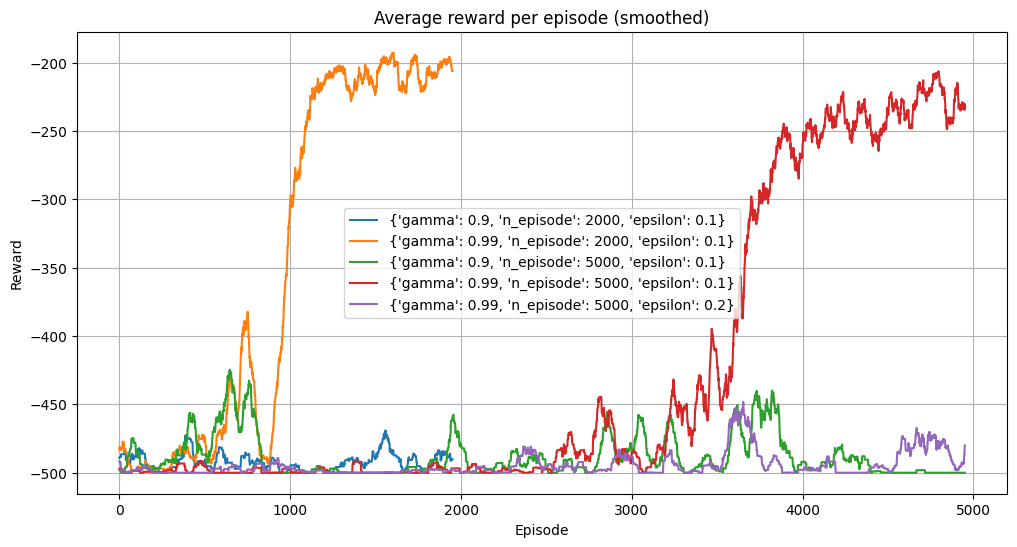

In [ ]:
param_grid_epsilon_greedy = [
    {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.1},
    {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.1},
    {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.1},
    {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.1},
    {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.2}
]

results_epsilon_greedy = run_experiments_epsilon_greedy(param_grid_epsilon_greedy)

Let's visualize the best result:

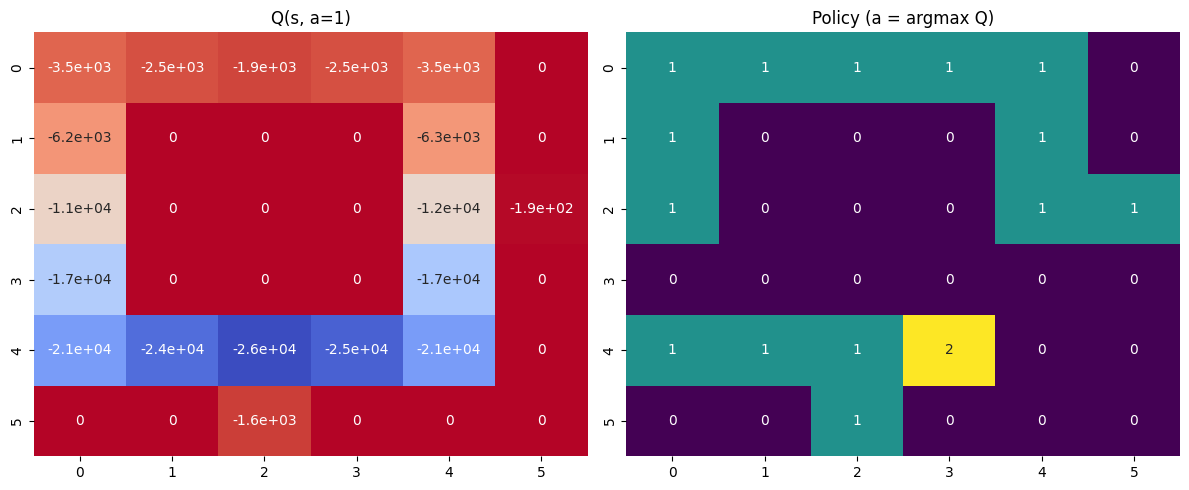

In [ ]:
visualize_q_and_policy(results_epsilon_greedy[1])

### Management by the MK method with a separate strategy

In [ ]:
def run_episode_behavioral(env, policy_b, n_action, bins):
    """
    Executes an episode guided by a random behavioral policy b.
    @param env: OpenAI Gym environment
    @param policy_b: behavioral policy (e.g. uniform)
    @param n_action: action space
    @param bins: list of bins to discretize the state
    @return: states, actions, rewards, and action probabilities b(a|s)
    """
    state, _ = env.reset()
    discrete_state = discretize_state(state, bins)

    rewards = []
    actions = []
    states = []
    probs = []

    while True:
        # Random action according to behavioral strategy
        action_probs = torch.ones(n_action) / n_action # uniform distribution
        action = torch.multinomial(action_probs, 1).item()
        prob = action_probs[action].item()

        actions.append(action)
        states.append(discrete_state)
        probs.append(prob)

        next_state, reward, done, terminated, info = env.step(action)
        rewards.append(reward)

        if done or terminated:
            break

        discrete_state = discretize_state(next_state, bins)

    return states, actions, rewards, probs

In [ ]:
def mc_control_separated_policy(env, gamma, n_episode, bins):
    """
    Monte Carlo with separate strategy (importance sampling).
    Behavioral strategy is random; objective strategy is greedy.
    @param env: OpenAI Gym environment name
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param bins: list of bins for discretization of states
    @return: optimal Q-function, policy, and reward history
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.zeros(n_action))  # Initialization Q(s,a)
    episode_rewards = []

    for episode in range(n_episode):
        # Collecting a trajectory with a behavioral strategy (uniform)
        states_t, actions_t, rewards_t, probs_t = run_episode_behavioral(env, None, n_action, bins)

        # Keeping the overall reward for the episode
        episode_rewards.append(sum(rewards_t))

        return_t = 0
        W = 1.0
        G = {}

        # Backward pass from end to beginning
        for t in reversed(range(len(states_t))):
            St = states_t[t]
            At = actions_t[t]
            Rt = rewards_t[t]

            return_t = gamma * return_t + Rt
            G_key = (St, At)
            G[G_key] = return_t

            # Get the probability of action according to the behavioral strategy
            pb = probs_t[t]

            # Greedy target strategy: π(a|s) = 1 if a == argmax(Q[s]), otherwise 0
            best_action = torch.argmax(Q[St]).item()
            pt = 1.0 if At == best_action else 0.0

            # Update the importance weight
            W *= pt / pb

            # Update Q only if W > 0 (otherwise skip)
            if W > 0:
                G_sum[G_key] += return_t * W
                N[G_key] += 1
                Q[St][At] = G_sum[G_key] / N[G_key]

    # Construction of an optimal policy
    policy = {s: torch.argmax(q).item() for s, q in Q.items()}

    return Q, policy, episode_rewards

In [ ]:
def run_experiments_separated_policy(param_grid, env_name='Acrobot-v1', num_bins=5):
    results = []
    env = gym.make(env_name)

    state_bounds = [
        [-1.0, 1.0], [-1.0, 1.0], [-1.0, 1.0],
        [-1.0, 1.0], [-4.0, 4.0], [-9.0, 9.0]
    ]
    bins = [np.linspace(low, high, num_bins + 1) for low, high in state_bounds]

    plt.figure(figsize=(12, 6))

    for idx, params in enumerate(param_grid):
        print(f"\nTraining with parameters: {params}")
        gamma = params['gamma']
        n_episode = params['n_episode']

        Q, policy, rewards = mc_control_separated_policy(
            env=env,
            gamma=gamma,
            n_episode=n_episode,
            bins=bins
        )

        smoothed_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed_rewards, label=str(params))

        results.append({
            'params': params,
            'Q': Q,
            'policy': policy,
            'rewards': rewards
        })

    plt.title("Average reward per episode (smoothed)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    env.close()
    return results


Training with parameters: {'gamma': 0.9, 'n_episode': 2000}

Training with parameters: {'gamma': 0.99, 'n_episode': 2000}

Training with parameters: {'gamma': 0.9, 'n_episode': 5000}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000}


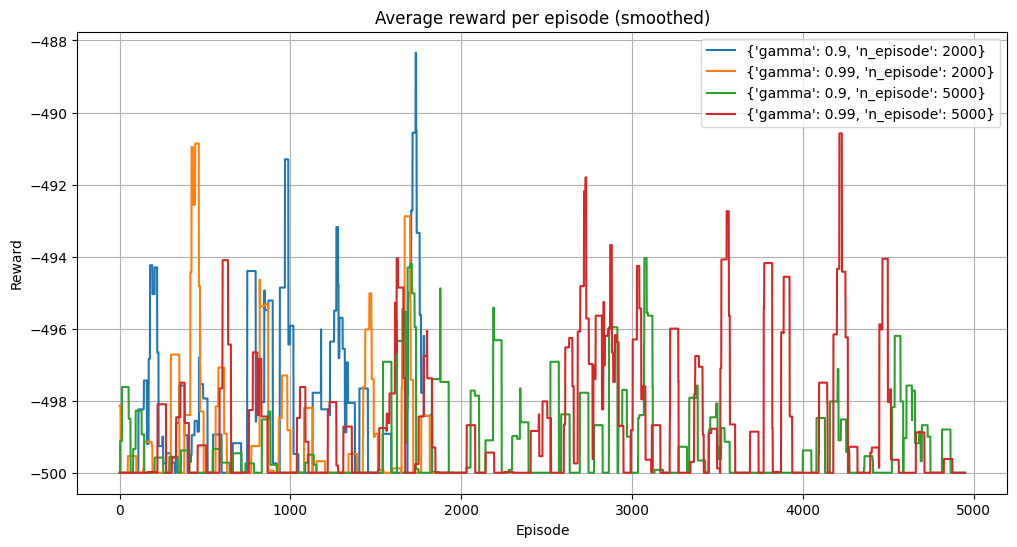

In [ ]:
param_grid_off_policy = [
    {'gamma': 0.9, 'n_episode': 2000},
    {'gamma': 0.99, 'n_episode': 2000},
    {'gamma': 0.9, 'n_episode': 5000},
    {'gamma': 0.99, 'n_episode': 5000}
]

results_off_policy = run_experiments_separated_policy(param_grid_off_policy, num_bins=8)

Let's visualize the best result:

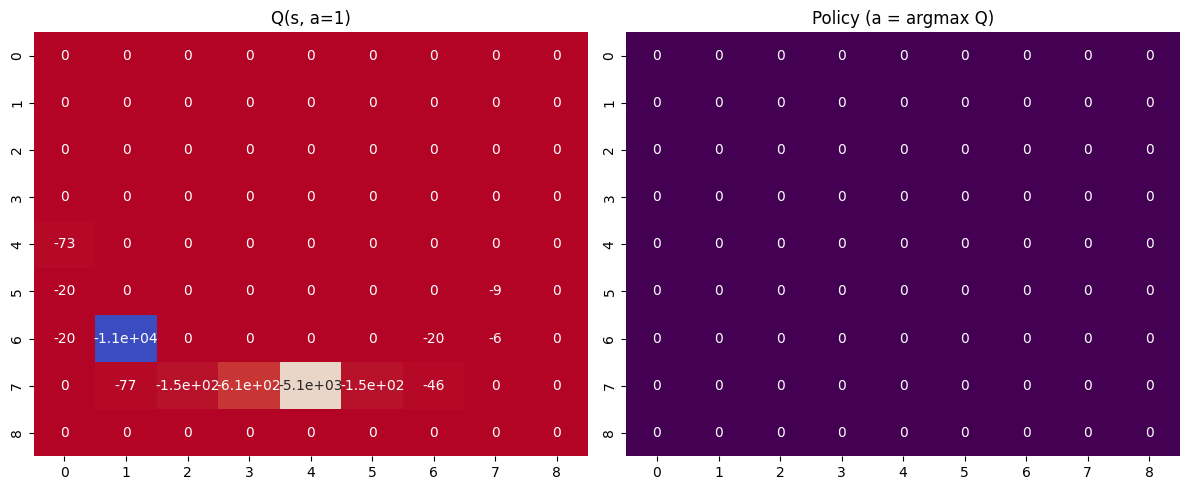

In [ ]:
visualize_q_and_policy(results_off_policy[0])

### Comparison of strategies

Average reward per episode

In [ ]:
def plot_comparison(results_list, labels, title="Comparison of Strategies"):
    plt.figure(figsize=(12, 6))

    for idx, (results, label) in enumerate(zip(results_list, labels)):
        # Take the rewards of the first experiment in the group
        rewards = results[0]['rewards'] # List of floats (one per episode)

        # Smooth with a moving average
        smoothed_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')

        # Рисуем график
        plt.plot(smoothed_rewards, label=label)

    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

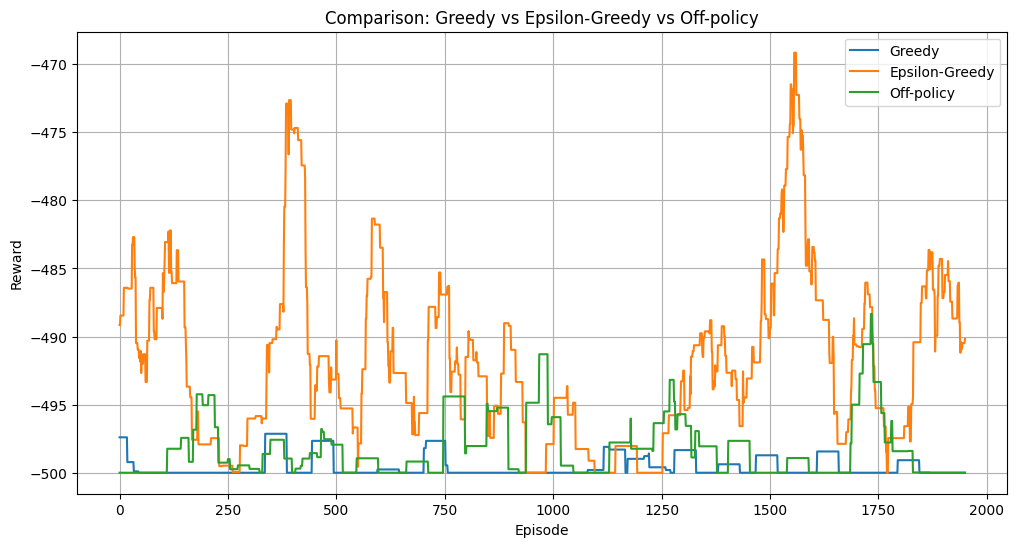

In [ ]:
plot_comparison(
    [results, results_epsilon_greedy, results_off_policy],
    ['Greedy', 'Epsilon-Greedy', 'Off-policy'],
    "Comparison: Greedy vs Epsilon-Greedy vs Off-policy"
)

Final Performance Analysis

In [ ]:
def final_performance(result, last_n=50):
    return np.mean(result[0]['rewards'][-last_n:])

greedy_perf = final_performance(results)
epsilon_perf = final_performance(results_epsilon_greedy)
off_policy_perf = final_performance(results_off_policy)

print(f"{'Strategy':<15} | {'Avg Reward (last 50 episodes)'}")
print("-" * 50)
print(f"{'Greedy':<15} | {greedy_perf:.2f}")
print(f"{'Epsilon-Greedy':<15} | {epsilon_perf:.2f}")
print(f"{'Off-policy':<15} | {off_policy_perf:.2f}")

Strategy        | Avg Reward (last 50 episodes)
--------------------------------------------------
Greedy          | -500.00
Epsilon-Greedy  | -490.16
Off-policy      | -500.00


Visualization of politics

In [ ]:
def visualize_policy_comparison(policy1, policy2, policy3, grid_size=10):
    policy_grid1 = np.zeros((grid_size, grid_size))
    policy_grid2 = np.zeros((grid_size, grid_size))
    policy_grid3 = np.zeros((grid_size, grid_size))

    for s in policy1:
        x, y = s[0], s[1]
        if x < grid_size and y < grid_size:
            policy_grid1[x, y] = policy1[s]
            policy_grid2[x, y] = policy2.get(s, -1)
            policy_grid3[x, y] = policy3.get(s, -1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(policy_grid1, annot=True, cmap="viridis", cbar=False, ax=axes[0])
    axes[0].set_title("Greedy Policy")

    sns.heatmap(policy_grid2, annot=True, cmap="viridis", cbar=False, ax=axes[1])
    axes[1].set_title("Epsilon-Greedy Policy")

    sns.heatmap(policy_grid3, annot=True, cmap="viridis", cbar=False, ax=axes[2])
    axes[2].set_title("Off-policy Policy")

    plt.tight_layout()
    plt.show()

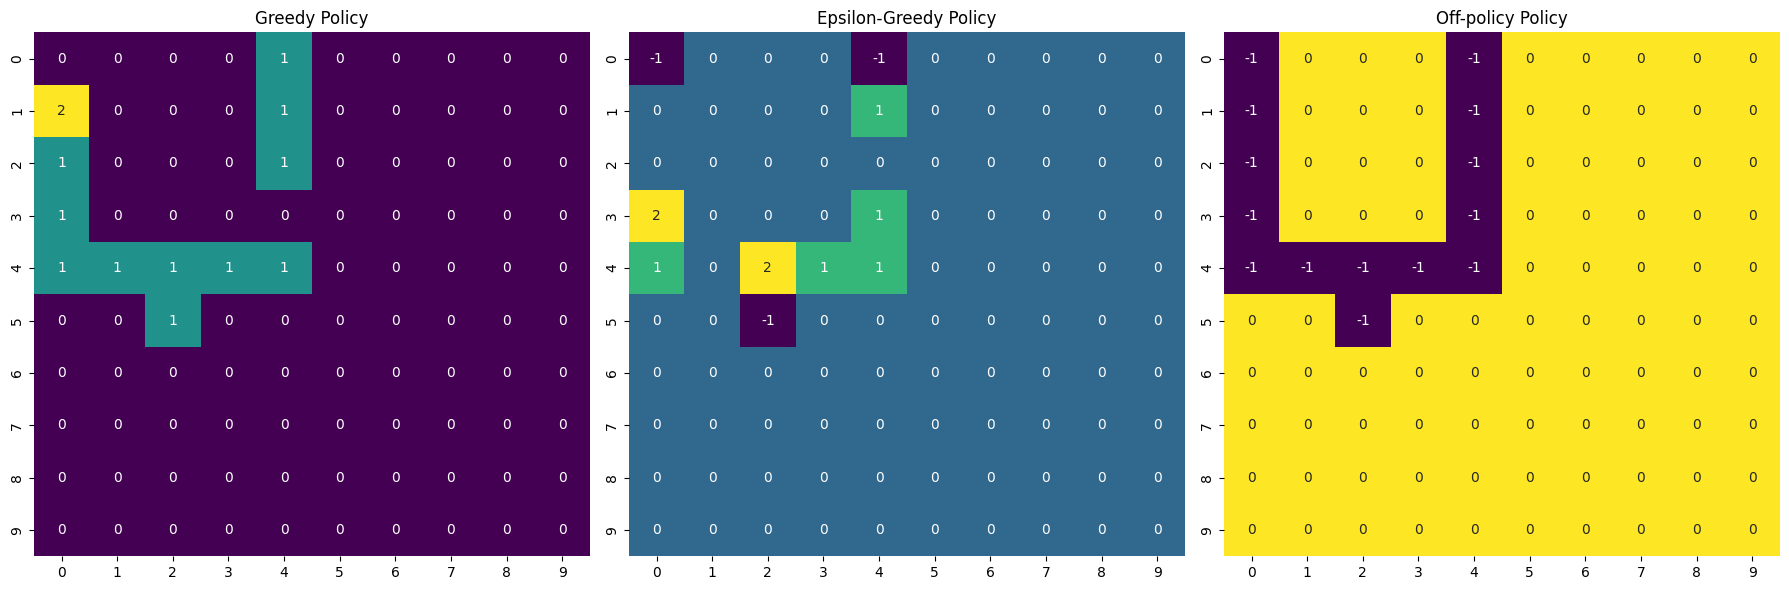

In [ ]:
visualize_policy_comparison(
    results[0]['policy'],
    results_epsilon_greedy[0]['policy'],
    results_off_policy[0]['policy']
)

We implement automatic selection of the best experiment based on:

* Average reward for the last N episodes (e.g. 50),
* Training stability (e.g. variance or moving average),
* Convergence rate (at which episode a good reward level was first achieved).

In [ ]:
def select_best_experiment(results_list, labels, last_n=50):
    """
    Selects the best experiment based on the average reward over the last last_n episodes.
    @param results_list: list of experiment results (each a run_experiments result)
    @param labels: strategy names
    @param last_n: number of last episodes to evaluate
    @return: index and label of the best experiment
    """
    performances = []

    for idx, result_group in enumerate(results_list):
        # We take the first launch from the group (you can average it over all)
        rewards = result_group[0]['rewards']
        avg_last_reward = np.mean(rewards[-last_n:])
        performances.append((idx, avg_last_reward))

    # Sort by average reward descending
    performances.sort(key=lambda x: x[1], reverse=True)
    best_idx, best_score = performances[0]

    print("\nComparison results:")
    print("-" * 40)
    for idx, score in performances:
        print(f"{labels[idx]:<20} | Average award: {score:.2f}")
    print("-" * 40)
    print(f"Best strategy: {labels[best_idx]} (Average award: {best_score:.2f})")

    return best_idx, labels[best_idx]

In [ ]:
# results — greedy strategy
# results_epsilon_greedy — ε-greedy
# results_off_policy — split strategy

results_list = [results, results_epsilon_greedy, results_off_policy]
labels = ['Greedy', 'Epsilon-Greedy', 'Off-policy']

best_idx, best_strategy = select_best_experiment(results_list, labels, last_n=50)


Comparison results:
----------------------------------------
Epsilon-Greedy       | Average award: -490.16
Greedy               | Average award: -500.00
Off-policy           | Average award: -500.00
----------------------------------------
Best strategy: Epsilon-Greedy (Average award: -490.16)


# Monte Carlo Method with Split Strategy for LunarLander Environment

In [ ]:
!pip install swig > /dev/null 2>&1
!pip install "gymnasium[box2d]" > /dev/null 2>&1

In [ ]:
env = gymnasium.make("LunarLander-v3", continuous=False, gravity=-10.0,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)

### State Discretization

In [ ]:
def discretize_state_lunar(state, bins):
    """
    Discretizes the state into a tuple of indices
    """
    return tuple(np.digitize(state[i], bins[i]) - 1 for i in range(len(state)))

In [ ]:
num_bins_lunar = 6  # number of bins per dimension

# Ranges of values ​​for each of the 8 state parameters
state_bounds_lunar = [
    [-1.0, 1.0], [-1.0, 1.0], [-5.0, 5.0], [-5.0, 5.0],
    [-3.14, 3.14], [-5.0, 5.0], [0.0, 1.0], [0.0, 1.0]
]

bins_lunar = [np.linspace(low, high, num_bins_lunar + 1) for low, high in state_bounds_lunar]

### Implementation of off-policy MC

In [ ]:
def mc_control_off_policy_lunar(env, gamma, n_episode, behavior_policy, bins):
    """
    Trains a Q function using Monte Carlo Off-policy Importance Sampling
    @param env: environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param behavior_policy: function returning action probabilities for a given state
    @param bins: list of arrays to sample
    @return: trained Q, policy, reward history
    """
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    C = defaultdict(float)
    episode_rewards = []

    for _ in range(n_episode):
        state, _ = env.reset()
        discrete_state = discretize_state_lunar(state, bins)
        trajectory = []

        while True:
            action_probs = behavior_policy(discrete_state)
            action = np.random.choice(n_action, p=action_probs.numpy())
            next_state, reward, done, truncated, _ = env.step(action)
            trajectory.append((discrete_state, action, reward))

            if done or truncated:
                break
            discrete_state = discretize_state_lunar(next_state, bins)

        episode_reward = sum(r for _, _, r in trajectory)
        episode_rewards.append(episode_reward)

        W = 1.0
        G = 0.0

        for t in reversed(range(len(trajectory))):
            state_t, action_t, reward_t = trajectory[t]
            G = gamma * G + reward_t
            C[(state_t, action_t)] += W
            Q[state_t][action_t] += (W / C[(state_t, action_t)]) * G

            best_action = torch.argmax(Q[state_t]).item()
            if action_t != best_action:
                break  # if the action is not optimal, we exit

            pi_b = action_probs[action_t].item()
            W *= 1. / pi_b

    policy = {s: torch.argmax(q).item() for s, q in Q.items()}
    return Q, policy, episode_rewards

### Implementation of the ε-greedy behavioral strategy

In [ ]:
def make_behavior_policy_lunar(Q, epsilon=0.1):
    def policy_fn(state):
        probs = torch.ones_like(torch.tensor([1.0]*Q[state].shape[0])) * epsilon / Q[state].shape[0]
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        return probs
    return policy_fn

### Experiment Launch Function

In [ ]:
def run_off_policy_experiments_lunar(param_grid, env_name='LunarLander-v3', num_bins=6):
    results = []
    env = gymnasium.make(env_name)

    state_bounds = [
        [-1.0, 1.0], [-1.0, 1.0], [-5.0, 5.0], [-5.0, 5.0],
        [-3.14, 3.14], [-5.0, 5.0], [0.0, 1.0], [0.0, 1.0]
    ]
    bins = [np.linspace(low, high, num_bins + 1) for low, high in state_bounds]

    plt.figure(figsize=(12, 6))

    for idx, params in enumerate(param_grid):
        print(f"\nTraining with parameters: {params}")
        gamma = params['gamma']
        n_episode = params['n_episode']
        epsilon = params['epsilon']

        behavior_policy = make_behavior_policy_lunar(defaultdict(lambda: torch.zeros(env.action_space.n)), epsilon=epsilon)

        Q, policy, rewards = mc_control_off_policy_lunar(
            env, gamma, n_episode, behavior_policy, bins
        )

        smoothed_rewards = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed_rewards, label=str(params))

        results.append({
            'params': params,
            'Q': Q,
            'policy': policy,
            'rewards': rewards
        })

    plt.title("Off-policy MC Control on LunarLander")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    env.close()
    return results


Training with parameters: {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.2}

Training with parameters: {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.2}

Training with parameters: {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.2}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.1}

Training with parameters: {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.2}


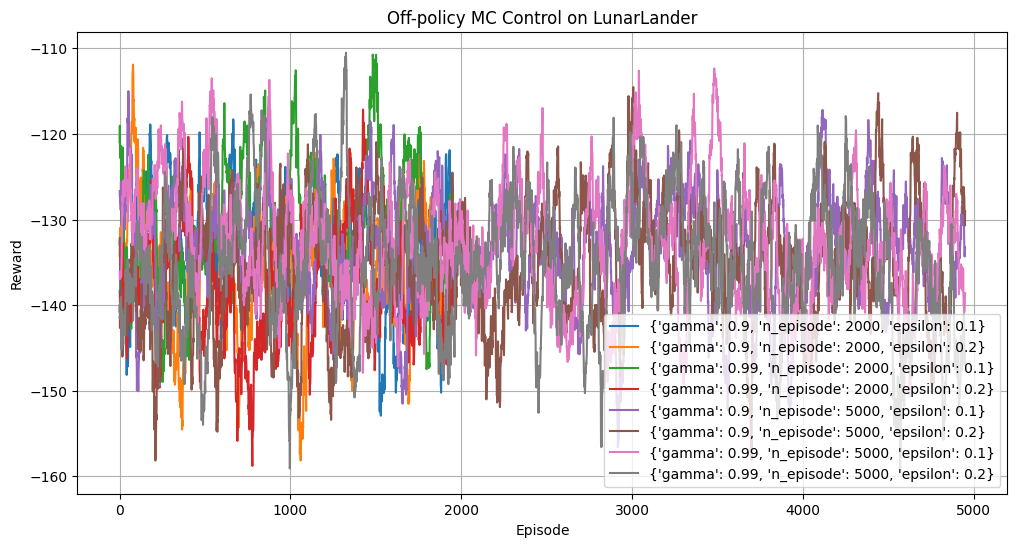

In [ ]:
param_grid_lunar = [
    {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.1},
    {'gamma': 0.9, 'n_episode': 2000, 'epsilon': 0.2},
    {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.1},
    {'gamma': 0.99, 'n_episode': 2000, 'epsilon': 0.2},
    {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.1},
    {'gamma': 0.9, 'n_episode': 5000, 'epsilon': 0.2},
    {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.1},
    {'gamma': 0.99, 'n_episode': 5000, 'epsilon': 0.2}
]

results_off_policy_lunar = run_off_policy_experiments_lunar(param_grid_lunar, num_bins=6)

### Policy Visualization and Q-Functions

In [ ]:
def visualize_q_and_policy_lunar(result, action_idx=2, grid_size=6):
    Q = result['Q']
    policy = result['policy']

    q_values = np.zeros((grid_size, grid_size))
    policy_grid = np.zeros((grid_size, grid_size))

    for s in Q:
        x, y = s[0], s[1]  # we use the first two dimensions
        if x < grid_size and y < grid_size:
            q_values[x, y] += Q[s][action_idx].item()
            policy_grid[x, y] = policy[s]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(q_values, annot=True, cmap="coolwarm", cbar=False)
    plt.title(f"Q(s, a={action_idx})")

    plt.subplot(1, 2, 2)
    sns.heatmap(policy_grid, annot=True, cmap="viridis", cbar=False)
    plt.title("Policy (a = argmax Q)")

    plt.tight_layout()
    plt.show()

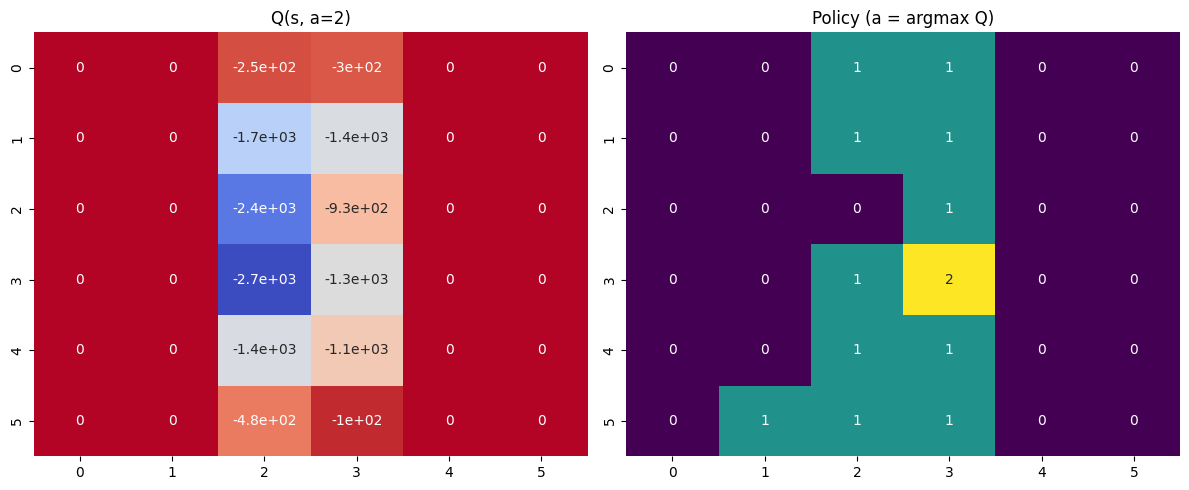

In [ ]:
visualize_q_and_policy_lunar(results_off_policy_lunar[7])